# Pokemon type classifier

This project takes a dataset with Pokémon sprites and trains a CNN to classify whether a Pokémon belongs to a certain type (e.g. water: true or false). It is meant as a demo to show how DVC can be used in deep learning scenarios.

## Imports and parameters

In [11]:
import math
import os
import re
import shutil
from pathlib import Path
from typing import Optional

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle

In [13]:
import tensorflow as tf

In [14]:
from keras.layers import (Activation, BatchNormalization, Conv2D, Dense,
                          Dropout, Flatten, MaxPooling2D)
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from sklearn.metrics import (ConfusionMatrixDisplay, classification_report,
                             confusion_matrix, log_loss, accuracy_score, f1_score,
                             precision_score, recall_score)
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers, regularizers
from tqdm import tqdm
import yaml

## Define variables

In [15]:
SEED: int = 42
POKEMON_TYPE_TRAIN: str = "Water"
    
SOURCE_DIRECTORY: str = "data/external"
DESTINATION_DIRECTORY: str = "data/processed"
TRAIN_DATA_IMAGES: str = "images"
TRAIN_DATA_LABELS: str = "stats/pokemon-gen-1-8.csv"

MODEL_TEST_SIZE: float = 0.2
MODEL_LEARNING_RATE: float = 0.001
MODEL_EPOCHS: int = 10
MODEL_BATCH_SIZE: int = 120

## Util: find root of Git project

In [16]:
def find_project_root() -> Optional[Path]:
    current = Path(".").resolve()
    
    while True:
        if (current / ".git").exists():
            return current
        
        if current.parent == current:
            print("WARNING: No .git dir found")
            return current
              
        current = current.parent
        

PROJECT_ROOT = find_project_root()

## Make sure the right directory structure exists

In [17]:
try:
    os.mkdir(PROJECT_ROOT / DESTINATION_DIRECTORY)
except:
    None
    
try:
    os.mkdir(PROJECT_ROOT / "outputs")
except:
    None

## Data preprocessing

In [18]:
# Process Pokémon and one-hot encode the types

def preprocess_training_labels(dataset) -> pd.DataFrame:
    pokemon = pd.read_csv(PROJECT_ROOT / SOURCE_DIRECTORY / dataset)
    pokemon = pokemon[["pokedex_number", "name", "type1", "type2"]]

    # Create one-hot columns for each type
    types = set(pokemon["type1"])
    for t in types:
        pokemon["is" + str(t).capitalize()] = 0

    # Iterate over Pokémon
    for i, p in pokemon.iterrows():

        #  Set one-hot columns to 1 for relevant types
        pokemon.loc[i, "is" + p["type1"].capitalize()] = 1

        if not pd.isna(p["type2"]):
            pokemon.loc[i, "is" + p["type2"].capitalize()] = 1
            
    # Save output    
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv', index=False)            
    return(pokemon)

pokemon = preprocess_training_labels(TRAIN_DATA_LABELS)
pokemon.head()

,pokedex_number,name,type1,type2,isWater,isFire,isDark,isGrass,isElectric,isIce,...,isNormal,isPsychic,isRock,isFlying,isFighting,isGhost,isDragon,isSteel,isBug,isGround
0,1,Bulbasaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,Ivysaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,Venusaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,Charmander,fire,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Charmeleon,fire,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [19]:
# Process image data

def preprocess_training_data(dataset) -> pd.DataFrame:

    data_directory_images = PROJECT_ROOT / SOURCE_DIRECTORY / dataset
    output_directory = PROJECT_ROOT / DESTINATION_DIRECTORY / "pokemon"

    pokemon = pd.read_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon.csv')
    pokemon["imagePath"] = np.nan

    # Remove processed folder and create empty new one
    try:
        shutil.rmtree(output_directory)
        os.mkdir(output_directory)
    except:
        os.mkdir(output_directory)

    # Copy images to processed folder
    for image in os.listdir(data_directory_images):
        pokemon_id = image.split('.')[0]

        # Add leading zeroes to ID
        while len(pokemon_id) < 3:
            pokemon_id = "0" + pokemon_id

        # Images with no variety (e.g. "211.png")
        if pokemon_id.isnumeric():

            # Copy to processed folder
            src = data_directory_images / image
            dst = os.path.join(output_directory, pokemon_id + ".png")
            shutil.copyfile(src, dst)

            # Set image path in data frame
            pokemon.loc[pokemon["pokedex_number"] == int(pokemon_id), 'imagePath'] = dst

    # Drop Pokemon without image path
    pokemon = pokemon.dropna(subset=["imagePath"])
    
    # Save pokemon.csv with image paths
    pokemon.to_csv(PROJECT_ROOT / DESTINATION_DIRECTORY / 'pokemon-with-image-paths.csv', index=False)
    
    return(pokemon)


pokemon = preprocess_training_data(TRAIN_DATA_IMAGES)
pokemon.head()

,pokedex_number,name,type1,type2,isWater,isFire,isDark,isGrass,isElectric,isIce,...,isPsychic,isRock,isFlying,isFighting,isGhost,isDragon,isSteel,isBug,isGround,imagePath
0,1,Bulbasaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,/Users/wasmer/src/forks/dtc-workshop/data/proc...
1,2,Ivysaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,/Users/wasmer/src/forks/dtc-workshop/data/proc...
2,3,Venusaur,grass,poison,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,/Users/wasmer/src/forks/dtc-workshop/data/proc...
3,4,Charmander,fire,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/wasmer/src/forks/dtc-workshop/data/proc...
4,5,Charmeleon,fire,NaN,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,/Users/wasmer/src/forks/dtc-workshop/data/proc...


## Load training data and create split

In [20]:
# Load training images
def load_training_data(labels) -> np.array:
    train_image = []

    for i in tqdm(range(labels.shape[0])):

        img = tf.keras.utils.load_img(labels.iloc[i]["imagePath"], color_mode='rgba')
        img = tf.keras.utils.img_to_array(img)
        img = img/255
        train_image.append(img)
    X = np.array(train_image)
    
    return(X)

X = load_training_data(pokemon)
X.shape

100%|██████████| 801/801 [00:05<00:00, 153.50it/s]


(801, 475, 475, 4)

In [21]:
# Create labels

def create_labels(labels):
    return(pokemon[["is" + POKEMON_TYPE_TRAIN]])

y = create_labels(pokemon)

In [22]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED, test_size=MODEL_TEST_SIZE, stratify=y)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(640, 475, 475, 4) (640, 1)
(161, 475, 475, 4) (161, 1)


In [23]:
# Save train and test data

pickle.dump(X, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X.pckl", "wb"))
pickle.dump(X_train, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X_train.pckl", "wb"))
pickle.dump(X_test, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "X_test.pckl", "wb"))

pickle.dump(y, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y.pckl", "wb"))
pickle.dump(y_train, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y_train.pckl", "wb"))
pickle.dump(y_test, open(PROJECT_ROOT / DESTINATION_DIRECTORY / "y_test.pckl", "wb"))

## Define model and train

In [24]:
def compile_model(model_image_size_x, model_image_size_y):
    img_input = layers.Input(shape=(model_image_size_x, model_image_size_y, 4))

    model = Sequential()

    model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01), input_shape=(model_image_size_x, model_image_size_y, 4)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Dropout(0.2))

    model.add(Conv2D(4, kernel_size=(5,5), activation='relu', kernel_regularizer=regularizers.l2(l=0.01)))
    model.add(MaxPooling2D(pool_size=(2, 2)))

    # model.add(Dropout(0.2))

    model.add(Dense(8, activation="relu"))

    model.add(Dropout(0.2))
    model.add(Flatten())

    model.add(Dense(1, activation="sigmoid"))

    # Legacy needed for M1/M2
    optimizer = keras.optimizers.legacy.Adam(learning_rate=0.001) #Adam, RMSprop or SGD

    model.compile(
        loss='binary_crossentropy'
        , optimizer=optimizer
        , metrics=[keras.metrics.AUC()]
    )

    model.summary()

    return(model)

model_image_size_x = len(X[1])
model_image_size_y = len(X[2])

model = compile_model(model_image_size_x, model_image_size_y)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 471, 471, 4)       404       
                                                                 
 max_pooling2d (MaxPooling2  (None, 235, 235, 4)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 235, 235, 4)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 231, 231, 4)       404       
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 115, 115, 4)       0         
 g2D)                                                            
                                                                 
 dense (Dense)               (None, 115, 115, 8)       4

In [25]:
# Now train the model

def train_estimator(model):
    def calculate_class_weights(y_train):
        ratio_true = sum(y_train["is" + POKEMON_TYPE_TRAIN] == 1) / len(y_train["is" + POKEMON_TYPE_TRAIN])
        ratio_false = sum(y_train["is" + POKEMON_TYPE_TRAIN] != 1) / len(y_train["is" + POKEMON_TYPE_TRAIN])

        return {0: ratio_true, 1: ratio_false}


    estimator = model.fit(X_train, y_train, 
                        validation_data=(X_test, y_test),
                        class_weight= calculate_class_weights(y_train),
                        epochs=MODEL_EPOCHS, 
                        batch_size=MODEL_BATCH_SIZE,
                        verbose=1)

    return(estimator)

estimator = train_estimator(model)

Epoch 1/10
6/6 [==============================] - 24s 4s/step - loss: 0.4818 - auc: 0.4685 - val_loss: 1.5918 - val_auc: 0.5732
Epoch 2/10
6/6 [==============================] - 23s 4s/step - loss: 0.2791 - auc: 0.6622 - val_loss: 0.5641 - val_auc: 0.5631
Epoch 3/10
6/6 [==============================] - 23s 4s/step - loss: 0.2682 - auc: 0.7356 - val_loss: 0.7193 - val_auc: 0.6343
Epoch 4/10
6/6 [==============================] - 23s 4s/step - loss: 0.2490 - auc: 0.8049 - val_loss: 0.8336 - val_auc: 0.6634
Epoch 5/10
6/6 [==============================] - 23s 4s/step - loss: 0.2520 - auc: 0.8502 - val_loss: 0.8343 - val_auc: 0.6447
Epoch 6/10
6/6 [==============================] - 23s 4s/step - loss: 0.2466 - auc: 0.8726 - val_loss: 0.7885 - val_auc: 0.6321
Epoch 7/10
6/6 [==============================] - 23s 4s/step - loss: 0.2389 - auc: 0.8968 - val_loss: 0.7291 - val_auc: 0.6177
Epoch 8/10
6/6 [==============================] - 23s 4s/step - loss: 0.2293 - auc: 0.9180 - val_loss: 0

## Plot training history and save model

INFO:tensorflow:Assets written to: /Users/wasmer/src/forks/dtc-workshop/outputs/model/assets


INFO:tensorflow:Assets written to: /Users/wasmer/src/forks/dtc-workshop/outputs/model/assets


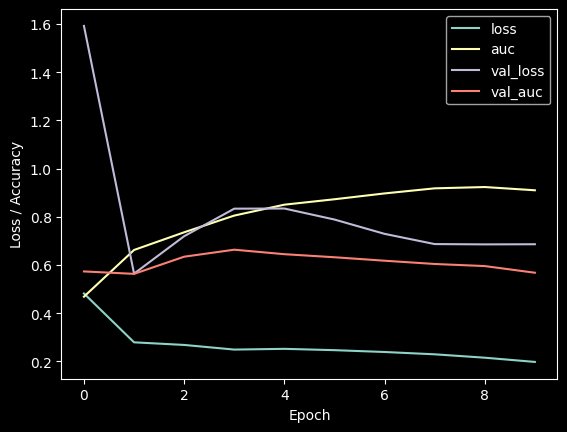

In [26]:
def save_estimator(estimator):
    # Training history
    plt.figure()
    plt.ylabel('Loss / Accuracy')
    plt.xlabel('Epoch')

    for k in estimator.history.keys():
        plt.plot(estimator.history[k], label = k) 
    plt.legend(loc='best')

    plt.savefig(PROJECT_ROOT / "outputs" / "train_history.png", dpi=150, bbox_inches='tight', pad_inches=0)

    # Save model itself
    model.save(PROJECT_ROOT / "outputs" / "model")
    
save_estimator(estimator)

## Validation

0.8033251


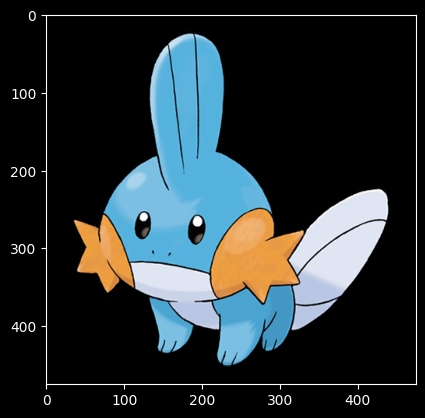

In [27]:
# Try on one Pokémon
def predict_pokemon(id: str, verbose=0):
    
    id = id.zfill(3)
    
    img = tf.keras.utils.load_img(PROJECT_ROOT/DESTINATION_DIRECTORY/'pokemon'/f'{id}.png', color_mode='rgba')
    img = tf.keras.utils.img_to_array(img)
    img = img/255


    classes = y
    proba = model.predict(img.reshape(1,475,475,4), verbose=verbose)
    
    plt.clf()
    plt.imshow(img)
    
    return proba[0][0]

print(predict_pokemon("258"))

In [28]:
# Load model
model = keras.models.load_model(PROJECT_ROOT / "outputs" / "model")

# Load data
X = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X.pckl").read_bytes())
X_train = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X_train.pckl").read_bytes())
X_test = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "X_test.pckl").read_bytes())

y = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y.pckl").read_bytes())
y_train = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y_train.pckl").read_bytes())
y_test = pickle.loads((PROJECT_ROOT / DESTINATION_DIRECTORY / "y_test.pckl").read_bytes())


In [29]:
# Predict all Pokémon
predictions = model.predict(X) > 0.5

26/26 [==============================] - 3s 102ms/step


In [30]:
# Calculate metrics
metrics = {}

metrics["acc"] = float(accuracy_score(y, predictions))
metrics["precision"] = float(precision_score(y, predictions))
metrics["recall"] = float(recall_score(y, predictions))
metrics["f1"] = float(f1_score(y, predictions))

# Save metrics
with open(PROJECT_ROOT / "outputs" / "metrics.yaml", 'w') as file:
    yaml.dump(metrics, file, default_flow_style=False)
    
print(metrics)

{'acc': 0.7865168539325843, 'precision': 0.4166666666666667, 'recall': 0.7633587786259542, 'f1': 0.5390835579514824}


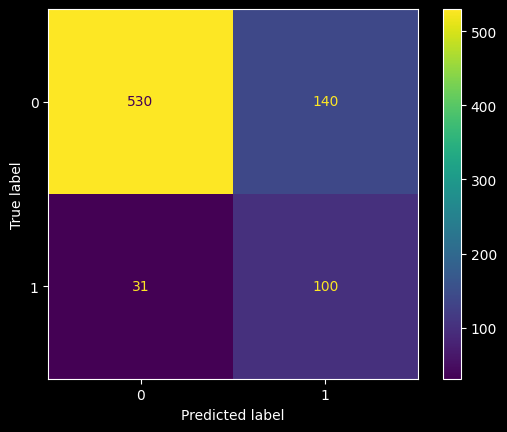

In [31]:
# Plot confusion matrix
cm = confusion_matrix(y, predictions)

disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

# Save confusion matrix
plt.savefig(PROJECT_ROOT / "outputs" / "confusion_matrix.png", dpi=150, bbox_inches='tight', pad_inches=0)

*Attribution*:

- https://github.com/benckx/dnn-movie-posters
- https://medium.com/m2mtechconnect/classifying-pok%C3%A9mon-images-with-machine-learning-79b9bc07c080
- https://www.kaggle.com/datasets/rounakbanik/pokemon